In [81]:
from datasets import load_dataset
import unicodedata
from transformers import T5Tokenizer, BartTokenizer
import numpy as np
import matplotlib.pyplot as plt

t5_base_tokenizer = T5Tokenizer.from_pretrained("t5-base")
bart_base_tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")


import re

def fix_encoding_errors(data):
    # This pattern matches one or more digits followed by an accented 'a'
    pattern = r'(\d+)Â'

    # See analysis in narrativeqa_encoding.ipynb
    data["source"] = (
        data["source"]
        .replace("â\x80\x94", ", ")
        .replace("Â\xa0â\x80\x93", " -")
        .replace("â\x80\x93", "-")
        .replace("â\x80\x99", "'")
        .replace("â\x80\x9d", "")
        .replace("â\x80\x9c", "")
        .replace("Ă˛", "")
        .replace("Ă\x89", "e")
        .replace("ÂŁ", "$")
        .replace("â\x80\x89", "")
        .replace("Ĺ\x8d", "o")
        .replace("â\x82Ź", "€")
    )
    data["source"] = re.sub(pattern, r'\1', data["source"])

    data["target"] = (
        data["target"]
        .replace("â\x80\x94", ", ")
        .replace("Â\xa0â\x80\x93", " -")
        .replace("â\x80\x93", "-")
        .replace("â\x80\x99", "'")
        .replace("â\x80\x9d", "")
        .replace("â\x80\x9c", "")
        .replace("Ă˛", "")
        .replace("Ă\x89", "e")
        .replace("ÂŁ", "$")
        .replace("â\x80\x89", "")
        .replace("Ĺ\x8d", "o")
        .replace("â\x82Ź", "€")
    )
    data["target"] = re.sub(pattern, r'\1', data["target"])

    return data

def contain_question_mark(data):
    return data["target"][-1].rstrip() == "?"

def calculate_length(data):
  data["input length"] = len(data["input_ids"])

  return data


def normalise(data):
    # Lowercase the text
    data["source"] = data["source"].lower()
    data["target"] = data["target"].lower()

    # Remove new line characters
    data["source"] = data["source"].replace("\n", " ")

    # Resolve accented characters
    data["source"] = "".join(
        c
        for c in unicodedata.normalize("NFD", data["source"])
        if unicodedata.category(c) != "Mn"
    )
    data["target"] = "".join(
        c
        for c in unicodedata.normalize("NFD", data["target"])
        if unicodedata.category(c) != "Mn"
    )

    return data

def categorise_dataset(data):
    target = data["target"].lower()
    if any(word in target for word in ["what"]):
        data["category"] = "description"
    elif any(
        word in target
        for word in [
            "where",
            "when",
            "who",
            "how many",
            "how much",
            "which",
            "how long",
        ]
    ):
        data["category"] = "recall"
    elif any(
        word in target
        for word in ["how did", "how does", "how do", "compute", "calculate"]
    ):
        data["category"] = "method"
    elif any(word in target for word in ["why"]):
        data["category"] = "explanation"

    return data

def remove_na_category(data):
    return data["category"] != "NA"

def convert_to_features_t5(x):
    input_encodings = t5_base_tokenizer.batch_encode_plus(
        x["source"],
        add_special_tokens=True,
    )
    target_encodings = t5_base_tokenizer.batch_encode_plus(
        x["target"],
        add_special_tokens=True,
    )

    encodings = {
        "input_ids": input_encodings["input_ids"],
        "labels": target_encodings["input_ids"],
        "attention_mask": input_encodings["attention_mask"],
    }

    return encodings

def convert_to_features_bart(x):
    input_encodings = bart_base_tokenizer.batch_encode_plus(
        x["source"],
        add_special_tokens=True,
    )
    target_encodings = bart_base_tokenizer.batch_encode_plus(
        x["target"],
        add_special_tokens=True,
    )

    encodings = {
        "input_ids": input_encodings["input_ids"],
        "labels": target_encodings["input_ids"],
        "attention_mask": input_encodings["attention_mask"],
    }

    return encodings

/Users/jiaweihong/Desktop/mmqg/.venv/lib/python3.11/site-packages/transformers/models/t5/tokenization_t5.py:240: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [82]:
narrative_data = (
  load_dataset("narrativeqa", trust_remote_code=True, split="train+validation+test")
  .select_columns(["document", "question"])
  .map(
      lambda x: {
          "document": x["document"]["summary"]["text"],
          "question": x["question"]["text"],
      }
  )
  .rename_columns({"document": "source", "question": "target"})
  .map(fix_encoding_errors)
)

narrative_data = narrative_data.add_column(
  "category", ["NA"] * len(narrative_data)
)

narrative_data = (
  narrative_data.filter(contain_question_mark)
  .map(normalise)
  .map(categorise_dataset)
  .filter(remove_na_category)
)

In [83]:
t5_tokenized_dataset = narrative_data.map(
    convert_to_features_t5,
    batched=True,
    batch_size=2000,
    remove_columns=["source", "target"],
)
t5_tokenized_dataset = t5_tokenized_dataset.add_column(
  "input length", ["NA"] * len(t5_tokenized_dataset)
)
t5_tokenized_dataset = t5_tokenized_dataset.map(calculate_length)
t5_tokenized_dataset = t5_tokenized_dataset.select_columns(["input length"])

bart_tokenized_dataset = narrative_data.map(
    convert_to_features_bart,
    batched=True,
    batch_size=2000,
    remove_columns=["source", "target"],
)
bart_tokenized_dataset = bart_tokenized_dataset.add_column(
  "input length", ["NA"] * len(bart_tokenized_dataset)
)
bart_tokenized_dataset = bart_tokenized_dataset.map(calculate_length)
bart_tokenized_dataset = bart_tokenized_dataset.select_columns(["input length"])



Map:   0%|          | 0/43612 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1286 > 512). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/43612 [00:00<?, ? examples/s]

Map:   0%|          | 0/43612 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1119 > 1024). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/43612 [00:00<?, ? examples/s]

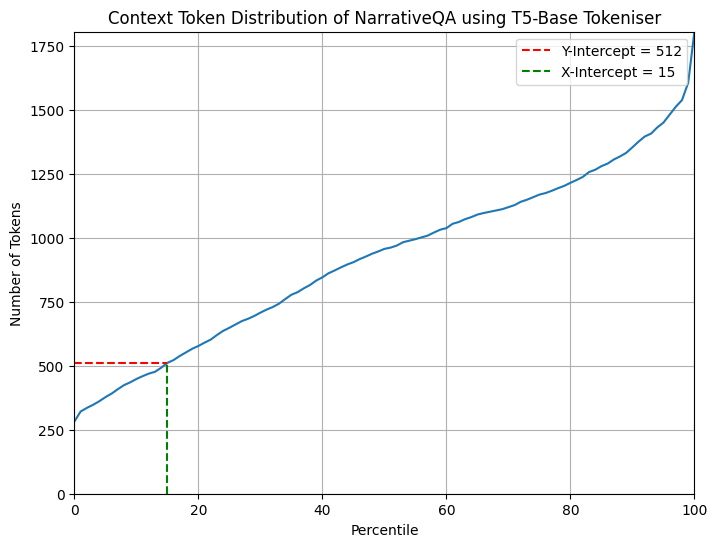

In [84]:
length_dataset = t5_tokenized_dataset['input length']

length_array = np.array(length_dataset)


percentiles = np.percentile(length_array, np.arange(0, 101, 1))  # Calculate percentiles from 0 to 100

plt.figure(figsize=(8, 6))
plt.plot(np.arange(0, 101, 1), percentiles, marker='', linestyle='-')

y_value = 512
#plt.axhline(y=y_value, color='r', linestyle='-', label=f'y = {y_value}')

x_value = np.argmin(np.abs(percentiles - y_value))
#plt.axvline(x=x_value, color='r', linestyle='-', label=f'x = {x_value}')

# Plotting the line up to the stop x-coordinate
plt.plot([0, x_value], [y_value, y_value], color='r', linestyle='--', label=f'Y-Intercept = {y_value}')
plt.plot([x_value, x_value], [0, y_value], color='g', linestyle='--', label=f'X-Intercept = {x_value}')


max_y = max(length_array)
plt.xlim(0, 100)
plt.ylim(0, max(length_array))

plt.xlabel('Percentile')
plt.ylabel('Number of Tokens')
plt.title('Context Token Distribution of NarrativeQA using T5-Base Tokeniser')
plt.grid(True)
plt.legend()
plt.show()

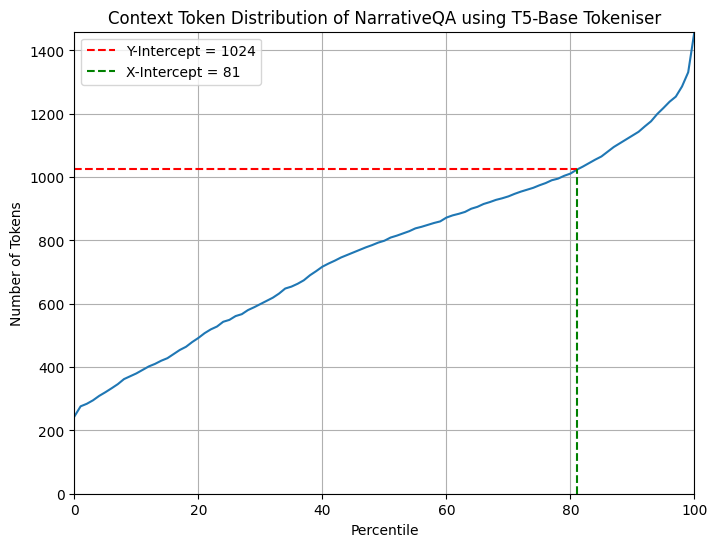

In [85]:
length_dataset = bart_tokenized_dataset['input length']

length_array = np.array(length_dataset)

percentiles = np.percentile(length_array, np.arange(0, 101, 1))  # Calculate percentiles from 0 to 100

plt.figure(figsize=(8, 6))
plt.plot(np.arange(0, 101, 1), percentiles, marker='', linestyle='-')

y_value = 1024
#plt.axhline(y=y_value, color='r', linestyle='-', label=f'y = {y_value}')

x_value = np.argmin(np.abs(percentiles - y_value))
#plt.axvline(x=x_value, color='r', linestyle='-', label=f'x = {x_value}')

# Plotting the line up to the stop x-coordinate
plt.plot([0, x_value], [y_value, y_value], color='r', linestyle='--', label=f'Y-Intercept = {y_value}')
plt.plot([x_value, x_value], [0, y_value], color='g', linestyle='--', label=f'X-Intercept = {x_value}')


max_y = max(length_array)
plt.xlim(0, 100)
plt.ylim(0, max(length_array))

plt.xlabel('Percentile')
plt.ylabel('Number of Tokens')
plt.title('Context Token Distribution of NarrativeQA using Bart Tokeniser')
plt.grid(True)
plt.legend()
plt.show()